# Modeling Kanwal (2007)

## Contents of readme

Each file in this dataset corresponds to one of the four experimental conditions described in the paper: 
* `Combined condition` (data_dyad_all_R_dem.csv), 
    * 24 frequent / 8 infrequent / total 32
* `Accuracy condition` (data_partner_only_all_R_dem.csv), 
    * 24 frequent / 8 infrequent / total 32
* `Time condition` (data_time_only_R_dem), 
    * 48 frequent / 16 infrequent / total 64
* `Neither condition` (data_min_R_dem.csv).
    * 48 frequent / 16 infrequent / total 64

Descriptions of the column headings are as follows:

* **pairnum** - the ID number of the pair
* **IP** - IP address of individual participant
* **timestamp** - time of data collection
* **counterbalance** - ID number of counterbalance condition (1, 2, 3, or 4)
* **code** - completion code entered by participant
* **trial** - director trial number (up to 32 in Combined & Accuracy conditions, up to 64 in Time and Neither conditions)
* **display** - 0/1 = frequent object displayed to director, 2/3 = infrequent object displayed
* **label** - label chosen by director (zop = short label)
* **button.side** - placement of button corresponding to the chosen label (R or L)
* **workerID** - turk worker ID of individual participant
* **age** - age of participant
* **gender** - gender of participant
* **L1** - participant's native language(s)
* **L2** - participant's other spoken language(s)
* **explanation** - explanation given by participant of their strategy during the director trials, from the exit survey

In [1]:
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdb
import random
import seaborn as sns

%matplotlib inline 

### Note: Runing into errors reading the csv directly so I'm writing some custom file parsing.

### Read data

In [2]:
def process_line(l):
    return list(map(lambda x: x.strip(), l.split(', ')))

def file2df(f_path, condition):
    data = []
    with open(f_path, 'r') as f:
        header = process_line(f.readline())
        for l in f.readlines():
            if l == '\n':
                continue
            curr_line = process_line(l)
            data.append({hdr: d for hdr, d in zip(header, curr_line)})

    df = pd.DataFrame(data)
    df['condition'] = condition
    return df

In [3]:
dir_path = '../materials/kanwal-jasmeen-2017-data/'
f_combined_path = os.path.join(dir_path, "data_dyad_all_R_dem.csv")
f_accuracy_path = os.path.join(dir_path, "data_partner_only_all_R_dem.csv")
f_time_path =     os.path.join(dir_path, "data_time_only_R_dem.csv")
f_neither_path =  os.path.join(dir_path, "data_min_R_dem.csv")

df_combined = file2df(f_combined_path, 'combined')
df_accuracy = file2df(f_accuracy_path, 'accuracy')
df_time =     file2df(f_time_path, 'time')
df_neither =  file2df(f_neither_path, 'neither')
# Columns match
assert all(df_combined.columns == df_accuracy.columns) and all(df_time.columns == df_neither.columns)

df_agg = df_combined.append(df_accuracy.append(df_time.append(df_neither)))
df_agg['trial'] = df_agg['trial'].apply(lambda x: int(x))
df_agg['display'] = df_agg['display'].apply(lambda x: int(x))

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


#### Minor preprocessing
* code for short vs long name

In [4]:
# def get_result(x, typ='infrequent'):
#     if typ == 'frequent':
#         return x['display'] <= 1 and x['label_type'] == 0
#     else:
#         return x['display'] > 1 and x['label_type'] == 0

df_agg['label_type'] = df_agg['label'].apply(lambda x: 'short' if x == 'zop' else 'long')
df_agg['display_type'] = df_agg['display'].apply(lambda x: 'frequent' if x < 2 else 'infrequent')

In [5]:
# Examine trial counts

# df_agg \
#     .groupby(['IP', 'condition', 'display_type']) \
#     .count()

In [6]:
df_agg['display_type_num'] = df_agg.apply(lambda x: 0 if x.display_type == 'frequent' else 1, axis=1)
df_agg['label_type_num'] = df_agg.apply(lambda x: 0 if x.label_type == 'short' else 1, axis=1)

### Create new trial orderings

For fig 5

In [43]:
groups = df_agg.groupby(['IP', 'display_type'])
groups_list = []
for g in groups:
    x = g[1]
    x['conditional_trial_num'] = range(1, len(x)+1)
    groups_list.append(x)
    
df_agg = pd.concat(groups_list)

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Combined data csv here

In [44]:
# df_agg.to_csv("../data/df_agg.csv")

In [23]:
IPs = set(df_agg['IP'])

## Cumulative trials

In [51]:
from collections import defaultdict, Counter

df_combined = df_agg.query('condition=="combined"')
d = defaultdict(list)
for index, row in df_combined.iterrows():
    d[row['IP']].append(row['display_type'])
    
d_counts = defaultdict(list)
for IP, trials in d.items():
    d_trials = []
    for i, t in enumerate(trials):
        if i > 0:
            d_trials.append(dict(Counter(trials[:i])))
    d_counts[IP] = d_trials

In [52]:
import json

In [53]:
# with open("participantTrajectories.json", 'w') as fp:
#     json.dump(d_counts, fp)

This plot is slow running

In [ ]:
IP = '73.246.28.166'
IP = '108.196.136.202'
p0 = sns.FacetGrid(col='IP', col_wrap=5, hue='display_type_num', data=df_agg.head(n=2000))
p0 = p0.map(sns.pointplot, "trial", "label_type_num", alpha=0.5)
# sns.pointplot(x='trial', y='label_type_num', hue='display_type', data=df_agg[df_agg['IP']==IP])

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


# Further preprocessing

* Fill missing rows (e.g. some participants never used `short` in `frequent` `accuracy` condition)

Helpers

In [7]:
def append_new_rows(x, missing_display_types, missing_label_types):
    n = len(missing_display_types)
    new_df = pd.DataFrame({
        'IP':           np.repeat(set(x['IP']).pop(), n),
        'condition':    np.repeat(set(x['condition']).pop(), n),
        'display_type': missing_display_types,
        'label_type':   missing_label_types,
        'cnt':          np.repeat(0, n)
    })
    x = x \
        .append(new_df) \
        .reset_index()
    return x

def fill_missing_rows(x):
    all_combns = set([
        ('frequent', 'long'), 
        ('infrequent', 'short'), 
        ('frequent', 'short'), 
        ('infrequent', 'long')])

    available_items = set(list(zip(x['display_type'], x['label_type'])))
    missing_items = all_combns - available_items
    missing_display_types = [d for (d, l) in missing_items]
    missing_label_types = [l for (d, l) in missing_items]
    x = append_new_rows(x, missing_display_types, missing_label_types)
    return x
    
def label_props(x):
    x['prop'] = x['cnt'] / sum(x['cnt'])
    return x

Primary data we'd like to model

In [8]:
def add_n(x):
    condition = x['condition'].values[0]
    if condition == 'combined':
        x['frequent_n'] = 24
        x['infrequent_n'] = 8
    elif condition == 'accuracy':
        x['frequent_n'] = 24
        x['infrequent_n'] = 8
    elif condition == 'time':
        x['frequent_n'] = 48
        x['infrequent_n'] = 16
    elif condition == 'neither':
        x['frequent_n'] = 48
        x['infrequent_n'] = 16
    else:
        raise Exception("{} condition unknown...".format())
    return x

df_short = df_agg \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .query('label_type == "short"') \
    .pivot_table(values='cnt', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index() \
    .groupby(['IP', 'condition']) \
    .apply(add_n) \
    .rename(columns={'frequent': 'frequent_cnt', 'infrequent': 'infrequent_cnt'})

# Alternative data form

In [11]:
df_shorts = df_agg \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .query('label_type == "short"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()
df_shorts['label_type'] = 'short'
df_shorts = pd.melt(df_shorts, 
                   id_vars=['IP', 'condition', 'label_type'], 
                   value_vars=['frequent', 'infrequent']) \
    .rename(columns={'value':'prop_short'})


df_longs = df_agg \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .drop(columns=['cnt']) \
    .query('label_type == "long"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()
df_longs['label_type'] = 'long'
df_longs = pd.melt(df_longs, 
                   id_vars=['IP', 'condition', 'label_type'], 
                   value_vars=['frequent', 'infrequent']) \
    .rename(columns={'value':'prop_long'})


In [84]:
merge_keys = ["IP", "condition", "display_type"]
df_merged = pd.merge(df_longs, df_shorts, left_on=merge_keys, right_on=merge_keys) \
    .drop(columns=["label_type_x", "label_type_y"])
assert all(df_merged["prop_long"] + df_merged["prop_short"] == 1)

In [86]:
df_merged.to_csv("../data/full_data_preprocessed.csv")

In [48]:
print(df_shorts.head())
print()
print(df_longs.head())

display_type               IP condition  frequent  infrequent label_type
0                100.10.40.83  combined  1.000000         0.0      short
1               100.2.122.157  combined  0.958333         0.0      short
2                104.11.62.66  accuracy  0.000000         0.0      short
3              104.174.222.43  combined  0.000000         0.5      short
4             104.175.214.163  accuracy  0.000000         0.0      short
()
display_type               IP condition  frequent  infrequent label_type
0                100.10.40.83  combined  0.000000         1.0       long
1               100.2.122.157  combined  0.041667         1.0       long
2                104.11.62.66  accuracy  1.000000         1.0       long
3              104.174.222.43  combined  1.000000         0.5       long
4             104.175.214.163  accuracy  1.000000         1.0       long


In [ ]:
df_props

In [20]:
df_agg_fig3 = df_agg \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()

In [21]:
df_agg_fig3

display_type,IP,condition,frequent,infrequent
0,100.10.40.83,combined,1.000000,0.0000
1,100.2.122.157,combined,0.958333,0.0000
2,104.11.62.66,accuracy,0.000000,0.0000
3,104.174.222.43,combined,0.000000,0.5000
4,104.175.214.163,accuracy,0.000000,0.0000
5,104.57.161.213,time,0.979167,1.0000
6,107.13.61.217,accuracy,0.000000,0.0000
7,107.161.163.8,combined,0.083333,0.0000
8,107.2.1.30,accuracy,0.000000,0.0000
9,107.2.206.59,neither,0.395833,0.3125


In [12]:
IP = '73.246.28.166'

df_agg_fig3[df_agg_fig3['IP'] == IP]

display_type,IP,condition,frequent,infrequent
97,73.246.28.166,combined,0.0,0.875


Output to CSV

In [17]:
# df_agg_fig3.to_csv('kanwal-preprocessed.csv')

## Reproducing fig 3

Note that this analysis looks slightly different likely because they only used data from the **second half of testing trials!**

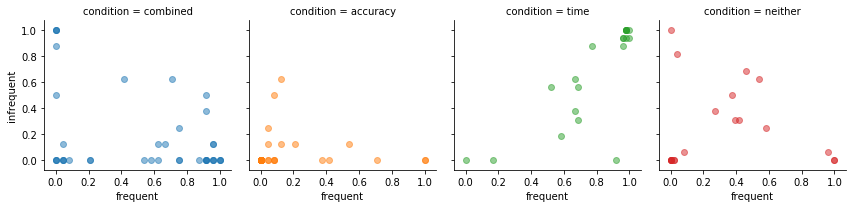

In [13]:
p1 = sns.FacetGrid(col='condition', hue='condition', data=df_agg_fig3)
p1 = p1.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [14]:
second_half_filter = \
    (df_agg['trial'] >= 16) & ((df_agg['condition'] == 'combined') | (df_agg['condition'] == 'accuracy')) | \
    (df_agg['trial'] >= 32) & ((df_agg['condition'] == 'time') | (df_agg['condition'] == 'neither'))

### Reproducing Fig3 - only using second half data...

Plot still looks different

In [15]:
df_fig3_second_half = df_agg[second_half_filter] \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()

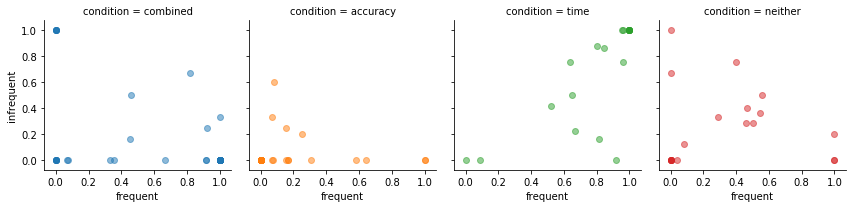

In [16]:
p2 = sns.FacetGrid(col='condition', hue='condition', data=df_fig3_second_half)
p2 = p2.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

# Data for BDA

* Note: This is data we can pass to `kanwal-BDA-2015.wppl`. That is, we'd like to infer various "strategies" employed by the participants (operationalized viz-a-viz the hyperparameters). Need a more explicit description of those.

* Once the prototype BDA / posterior predictive is working need to figure out how to deal with full dataset.

### Combined condition

Data for fitting hyperparams

In [22]:
def diag_top(x, y):
    return y <= (0.88*x + 0.2)

def diag_bottom(x, y):
    return y >= (1.12*x-0.2)

def y_axis(x, y):
    return y <= -5 * (x-0.2)

def x_axis(x, y):
    return y <= -0.2*x + 0.2

def is_in_modelable_area(x, y):
    """Filter modelable data. 
    
    This is currently a huerstic approach that needs to be changed.
    Some participant are behaving in distinctly sub-optimal ways that either reflect
    convention formation or randomness (see Kanwal, 2017). Ideally, we could also capture
    that behavior, but for this proof-of concept we keep it to this.
    """
    return (diag_top(x, y) and diag_bottom(x, y)) or (y_axis(x, y) or x_axis(x, y))

is_in_modelable_area(0.0, 0.5)

True

In [23]:
df_agg_fig3['isModelable'] = df_agg_fig3 \
    .apply(lambda x: is_in_modelable_area(x['frequent'], x['infrequent']), axis=1)
df_agg_fig3 = df_agg_fig3 \
    .assign(
        frequent=lambda x: round(x.frequent, 2),
        infrequent=lambda x: round(x.infrequent, 2))

### Problem participants

In [24]:
print('num:\t{}'.format(len(df_agg_fig3.query('isModelable'))))

with pd.option_context('display.max_rows', None):
    print(df_agg_fig3.query('not isModelable'))

num:	105
display_type               IP condition  frequent  infrequent  isModelable
10            108.196.136.202  accuracy      0.12        0.62        False
13             108.250.206.38   neither      0.58        0.25        False
19              117.217.210.9   neither      0.04        0.81        False
21              122.161.26.31  combined      0.42        0.62        False
36             184.155.134.46      time      0.69        0.56        False
40             200.106.22.194  accuracy      0.54        0.12        False
45              24.113.49.186      time      0.58        0.19        False
50              24.20.229.200  combined      0.96        0.12        False
51             24.253.233.194  combined      0.96        0.12        False
54               24.74.13.244      time      0.69        0.31        False
58             50.153.162.232  combined      0.75        0.25        False
64                59.93.15.89  combined      0.62        0.12        False
67             6

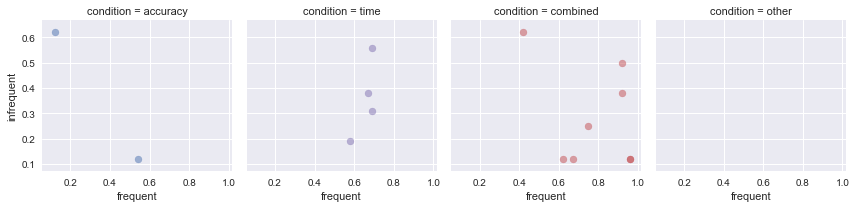

In [25]:
df_problems = df_agg_fig3.query('not isModelable')
p0 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combined', 'other'], data=df_problems)
p0 = p0.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [26]:
df_modelable = df_agg_fig3.query('isModelable')

In [27]:
# df_modelable.drop(columns='isModelable').to_json("modelable-data-20180330.json", orient='records')
# df_modelable.drop(columns='isModelable').to_csv("modelable-data-20180330.csv")
print("Percentage of respondents modelable:\t{}".format(len(df_modelable) / len(df_agg_fig3)))

Percentage of respondents modelable:	0.8536585365853658


## Model output

#### Combination

### TEst

In [34]:
f_test = './json/synthetic-exp-data-20180330.json'

In [35]:
df_test = pd.read_json(f_test, orient='records')
df_test = df_test.rename(columns={'trialType':'display_type', 'participantNum':'IP'})
df_test['label_type'] = ['short' if u == 'zop' else 'long' for u in df_test['utterance']]

ValueError: Expected object or value

In [42]:
def normer(x):
    x['prop'] = x['cnt'] / np.sum(x['cnt'])
    return x

def get_label_type(x):
    pdb.set_trace()
    x['label_type'] = 'short' if x['utterance'] == 'zop' else 'long'
    return x
    

df_props = df_test \
    .groupby(['condition', 'IP', 'display_type', 'label_type']) \
    .count()[['trialNum']] \
    .rename(columns={'trialNum': 'cnt'}) \
    .reset_index() \
    .groupby(['condition', 'IP']) \
    .apply(fill_missing_rows) \
    .drop(columns='index') \
    .set_index(['IP']) \
    .reset_index() \
    .groupby(['condition', 'IP', 'display_type']) \
    .apply(normer) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .reset_index() \
    .drop(columns='index') \
    .pivot_table(values='prop', index=['condition', 'IP'], columns=['display_type']) \
    .reset_index()

In [43]:
df_props

display_type,condition,IP,frequent,infrequent
0,accuracy,104.11.62.66,0.000000,0.0
1,accuracy,104.175.214.163,0.000000,0.0
2,accuracy,107.13.61.217,0.000000,0.0
3,accuracy,107.2.1.30,0.000000,0.0
4,accuracy,108.210.65.252,0.000000,0.0
5,accuracy,108.23.68.36,0.000000,0.0
6,accuracy,115.241.81.138,0.000000,0.0
7,accuracy,115.242.129.102,0.000000,0.0
8,accuracy,115.98.55.114,0.000000,0.0
9,combined,107.161.163.8,0.041667,0.0


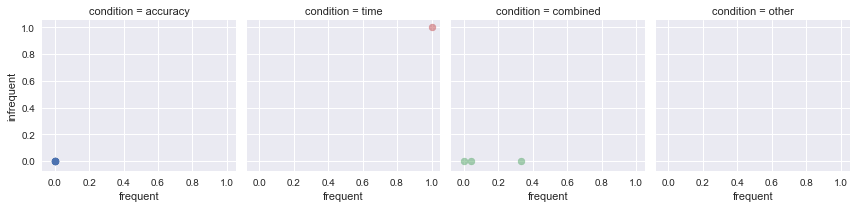

In [34]:
p3 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combined', 'other'], data=df_props)
p3 = p3.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [35]:
f_combination = 'combination.json'
f_accuracy = 'accuracy.json'
f_time = 'time.json'
f_other = 'other.json'
df_synthetic = pd.read_json(f_accuracy, orient='records') \
    .append([pd.read_json(f_time, orient='records'), 
             pd.read_json(f_combination, orient='records'),
             pd.read_json(f_other, orient='records')])

### Purely synthetic

In [36]:
df_synthetic = df_synthetic.rename(columns={'trialType':'display_type', 'participantNum':'IP'})
df_synthetic['label_type'] = ['short' if u == 'zop' else 'long' for u in df_synthetic['utterance']]

In [37]:
def normer(x):
    x['prop'] = x['cnt'] / np.sum(x['cnt'])
    return x

def get_label_type(x):
    pdb.set_trace()
    x['label_type'] = 'short' if x['utterance'] == 'zop' else 'long'
    return x
    

df_props = df_synthetic \
    .groupby(['condition', 'IP', 'display_type', 'label_type']) \
    .count()[['trialNum']] \
    .rename(columns={'trialNum': 'cnt'}) \
    .reset_index() \
    .groupby(['condition', 'IP']) \
    .apply(fill_missing_rows) \
    .drop(columns='index') \
    .set_index(['IP']) \
    .reset_index() \
    .groupby(['condition', 'IP', 'display_type']) \
    .apply(normer) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .reset_index() \
    .drop(columns='index') \
    .pivot_table(values='prop', index=['condition', 'IP'], columns=['display_type']) \
    .reset_index()


In [38]:
# p = sns.lmplot(x='frequent', y='infrequent', hue='condition',
#                 fit_reg=False, y_jitter=0.1,
#                 scatter_kws={'alpha':0.5}, data=df_props)
# plt.xlim(0, 1)
# plt.ylim(0, 1)

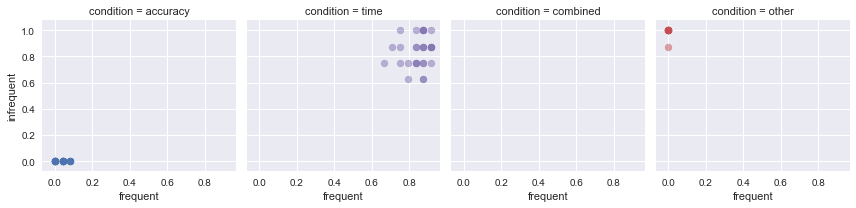

In [39]:
p3 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combined', 'other'], data=df_props)
p3 = p3.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

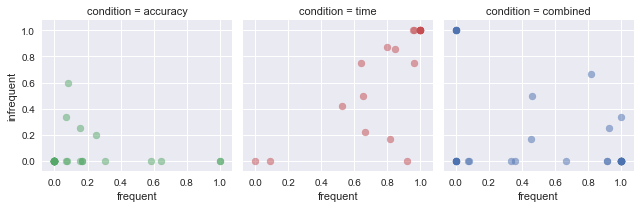

In [218]:
curr_df = df_fig3_second_half[df_fig3_second_half['condition'].isin(['time', 'accuracy', 'combined'])]
p2 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combined'], data=curr_df)
p2 = p2.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [100]:
def isModelable(x):
    freq = x['frequent']
    infreq = x['infrequent']
    x['isModelable'] = np.abs(freq - infreq) < 0.1 or np.abs(freq - infreq) < 0.1

df_props \
    .apply()

display_type,condition,IP,frequent,infrequent
0,accuracy,0,0.083333,0.000
1,accuracy,1,0.000000,0.000
2,accuracy,2,0.000000,0.000
3,accuracy,3,0.083333,0.000
4,accuracy,4,0.000000,0.000
5,accuracy,5,0.041667,0.000
6,accuracy,6,0.000000,0.000
7,accuracy,7,0.041667,0.000
8,accuracy,8,0.041667,0.000
9,accuracy,9,0.041667,0.000


In [202]:
# fn - '-x\sin a+y\cos a\ =\left(\ x\cos a+y\sin a-h\right)^2+k'
def good_xy(x, y):
    sm = x + y
    if (sm) < 1:
        return np.abs(x - y) <= 0.1 or (x == 0 or y == 0)
    elif (sm > 1):
        return np.abs(x - y) <= 0.1
    else:
        return False
    
# trials = [(0.12, 0.62)]
# good_xy(0.12, 0.62)

False

In [206]:
trials = [
  {'IP': '68.194.164.153',
  'condition': 'accuracy',
  'frequent': 0.0,
  'infrequent': 0.0},
 {'IP': '115.99.18.32',
  'condition': 'combined',
  'frequent': 0.21,
  'infrequent': 0.0},
 {'IP': '182.65.31.144',
  'condition': 'combined',
  'frequent': 0.75,
  'infrequent': 0.0},
    {'IP': '75.134.222.94',
     'condition': 'accuracy',
     'frequent': 0.08,
     'infrequent': 0.5},
 {'IP': '107.161.163.8',
  'condition': 'combined',
  'frequent': 0.08,
  'infrequent': 0.0},
    {'IP': '108.196.136.202',
     'condition': 'accuracy',
     'frequent': 0.12,
     'infrequent': 0.62},
 {'IP': '216.21.204.80',
  'condition': 'neither',
  'frequent': 1.0,
  'infrequent': 0.0},
 {'IP': '50.153.191.59',
  'condition': 'accuracy',
  'frequent': 0.0,
  'infrequent': 0.0},
    {'IP': '70.198.5.150',
     'condition': 'neither',
     'frequent': 0.96,
     'infrequent': 0.06},
 {'IP': '50.157.182.233',
  'condition': 'accuracy',
  'frequent': 0.0,
  'infrequent': 0.0},
 {'IP': '108.210.65.252',
  'condition': 'accuracy',
  'frequent': 0.0,
  'infrequent': 0.0},
 {'IP': '71.112.135.232',
  'condition': 'accuracy',
  'frequent': 0.0,
  'infrequent': 0.0},
    {'IP': '24.20.229.200',
     'condition': 'combined',
     'frequent': 0.96,
     'infrequent': 0.12},
 {'IP': '65.28.161.177',
  'condition': 'time',
  'frequent': 0.98,
  'infrequent': 1.0},
 {'IP': '163.47.15.206',
  'condition': 'combined',
  'frequent': 0.21,
  'infrequent': 0.0},
 {'IP': '66.56.8.213',
  'condition': 'combined',
  'frequent': 0.62,
  'infrequent': 0.0},
 {'IP': '96.60.207.27',
  'condition': 'time',
  'frequent': 0.96,
  'infrequent': 0.88},
 {'IP': '67.44.209.240',
  'condition': 'neither',
  'frequent': 0.02,
  'infrequent': 0.0},
 {'IP': '68.184.74.170',
  'condition': 'time',
  'frequent': 0.67,
  'infrequent': 0.62}]

badIds = [t['IP'] for t in trials if not good_xy(t['frequent'], t['infrequent'])]

In [207]:
badIds

['75.134.222.94',
 '108.196.136.202',
 '216.21.204.80',
 '70.198.5.150',
 '24.20.229.200']

In [ ]:
75.134.222.94
108.196.136.202
70.198.5.150
24.20.229.200

In [44]:
df_props_mod = df_props[['IP', 'condition', 'frequent', 'infrequent']] \
    .rename(columns={'frequent':'gen_freq', 'infrequent':'gen_infreq'})
    
df_joined = df_props_mod.set_index(['IP', 'condition']).join(df_agg_fig3.set_index(['IP', 'condition'])) \
    .reset_index()

In [45]:
# pd.melt(df, id_vars=['A'], value_vars=['B'])
df_joined_melted = pd.melt(df_joined, id_vars=['IP', 'condition'], value_vars=['gen_freq', 'gen_infreq', 'frequent', 'infrequent'])
# df_joined_melted['data_type'] = df_joined_melted[['data_type']]

In [46]:
def isEmpirical(x):
    return x == 'frequent' or x == 'infrequent'
def isFrequent(x):
    return x == 'gen_freq' or x == 'frequent'

df_joined_melted
df_joined_melted['data_type'] = ['empirical' if isEmpirical(x) else 'generated' for x in df_joined_melted['display_type']]
df_joined_melted['display_type2'] = ['frequent' if isFrequent(x) else 'infrequent' for x in df_joined_melted['display_type']]

In [47]:
df_joined_melted_pivoted = df_joined_melted.drop(columns='display_type') \
    .pivot_table(values='value', index=['IP', 'condition', 'data_type'], columns=['display_type2']) \
    .reset_index()
df_joined_melted_pivoted.head()

display_type2,IP,condition,data_type,frequent,infrequent
0,104.11.62.66,accuracy,empirical,0.000000,0.0
1,104.11.62.66,accuracy,generated,0.000000,0.0
2,104.175.214.163,accuracy,empirical,0.000000,0.0
3,104.175.214.163,accuracy,generated,0.000000,0.0
4,104.57.161.213,time,empirical,0.979167,1.0


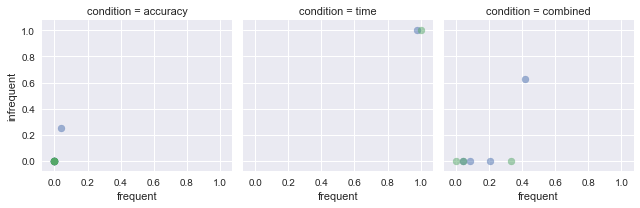

In [48]:
# df_props
p4 = sns.FacetGrid(col='condition', hue='data_type', col_order=['accuracy', 'time', 'combined'], data=df_joined_melted_pivoted)
p4 = p4.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [49]:
df_frequent_corr = df_joined_melted_pivoted \
    .drop(columns='infrequent') \
    .pivot_table(values='frequent', index=['IP', 'condition',], columns=['data_type']) \
    .reset_index()

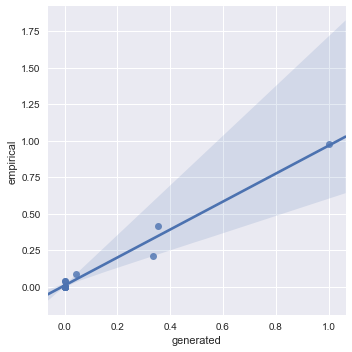

In [50]:
sns.lmplot(x='generated', y='empirical', data=df_frequent_corr)

In [51]:
np.corrcoef(df_frequent_corr['generated'], df_frequent_corr['empirical'])**2

array([[ 1.        ,  0.97573957],
       [ 0.97573957,  1.        ]])

## Figure 4 - optimal strategies

In [14]:
# forms
f_zop = 0.75
f_zopudon = 0.0
f_zopekil = 0.25

# meanings
m_zopudon = 0.75
m_zopekil = 0.25

# p_fm
p_zop_zopudon = 0.75
p_zop_zopekil = 0
p_zopekil_zopekil = 0.25
p_zopudon_zopudon = 0
p_zopekil_zopudon = 0
p_zopudon_zopekil = 0

In [15]:
def MI(p_x, p_y, p_xy):
    if p_x == 0 or p_y == 0 or p_xy == 0:
        return 0
    return p_xy * np.log2(p_xy / (p_x * p_y))

In [16]:
distr = [(f_zop, m_zopudon, p_zop_zopudon),
         (f_zop, m_zopekil, p_zop_zopekil), 
         (f_zopekil, m_zopekil, p_zopekil_zopekil),
         (f_zopudon, m_zopudon, p_zopudon_zopudon),
         (f_zopekil, m_zopudon, p_zopekil_zopudon),
         (f_zopudon, m_zopekil, p_zopudon_zopekil)]

In [17]:
res = [MI(p_x, p_y, p_xy) for (p_x, p_y, p_xy) in distr]
np.sum(res)

0.81127812445913283